Each task that is proposed to be completed as part of the homework has a declared "price" in points. The maximum possible amount is 10 points, and together with the bonus assignment - 12 points. It is not necessary to complete all the tasks, only a part can be done. Most of the points expect you to write working Python code; sometimes you will need to write comments - for example, to compare several approaches to solve the same problem. Also you can add more cells for your convenience if you need.

This homework focuses on clustering. We will work with images of handwritten digits, learn how to cluster them using two different methods (hierarchical clustering and the 𝐾-means algorithm), evaluate the quality of the partition and choose the optimal number of clusters, as well as visualize intermediate results.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_digits
from sklearn.manifold import TSNE

## 1. Loading data
The data we will be working with is available in the scikit-learn library (`sklearn` module) in the `datasets` submodule via the `load_digits` function. The data contains 1,797 observations, each of which is 8×8 pixel image of a handwritten digit from 0 to 9. This is about the same amount of each digit (about 180).

For convenience, every image expands to a 64 (8×8) row, so entire numpy array is 1797×64. The color intensity in each pixel is encoded with an integer from 0 to 16.

In addition to images, their labels are also known. In this task, we will assume that the labels (as well as their amount) are unknown and try to group the data in such a way that the resulting clusters 'better match' the original ones. Possible options for determining the 'better match' are presented later.

**(0.25 points)** Load the images into `X` variable, and their labels into `y` variable.

In [2]:
digits = load_digits()
X = digits.data
y = digits.target

In [3]:
assert X.shape == (1797, 64)
assert y.shape == (1797,)

**(0.5 points)** Visualize the first 10 images.

- Arrange images on a grid rather than in a row. You may need the `subplot` and `imshow` functions from the `pyplot` module in the `matplotlib` library.
- You will also need to reshape the images to 8×8.
- Remove ticks and labels from both axes. The `xticks` and `yticks` functions or the `tick_params` function from `pyplot` can help you with this.
- Make the output good sized with the `figure` function from `pyplot`.

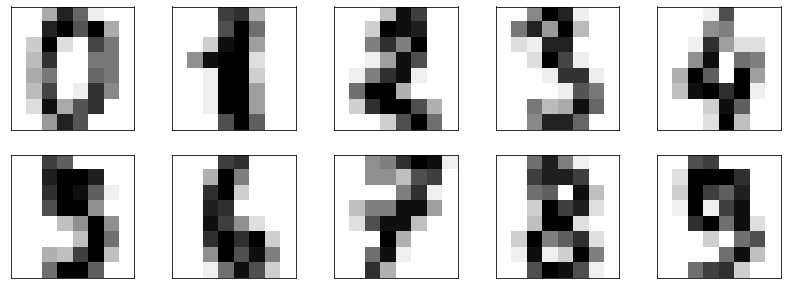

In [4]:
fig, axs = plt.subplots(2, 5, figsize=(14, 5))
for n in range(10):
    axs[n // 5, n % 5].imshow(digits.images[n], cmap=plt.cm.binary)
    axs[n // 5, n % 5].set_xticks([])
    axs[n // 5, n % 5].set_yticks([])

## 2. Clustering and quality evaluation

**(2 points)** Implement the the KMeans algorithm. Use objective function $L = \sum_{i=1}^{n}|x_{i}-Z_{A(x_{i})}|^{2}$, where $Z_{A(x_{i})}$ is the center of the cluster corresponding to $x_{i}$ object.

In [5]:
from sklearn.exceptions import NotFittedError
from numpy.random import RandomState
from sklearn.metrics import pairwise_distances

In [6]:
# Еще одна реализация алгоритма, изучаемого на курсе Introduction (!) to Machine Learning... Спасибо, больше не надо.
class CustomKMeans:
    pass

**(1 points)** Get the `X` array partition into 10 clusters. Visualize the centers of clusters.
- We will assume that the center of the cluster is average value of all observations belonging to the cluster.
- The cluster centers should have the same shape as our observations (64). So you have to average the points across the rows.

In [7]:
pass

**(0.5 points)** Experiment with `max_iter` and `n_init` parameters. Look at the range of values of the objective function, it's best values, at what parameters and how often they are achieved.

In [8]:
pass

Now we will use two popular algorithms: hierarchical clustering and $K$-means clustering. These and other algorithms are available in the `scikit-learn` module in the `cluster` submodule. Hierarchical clustering is called `AgglomerativeClustering`, and the $K$-means method is called `KMeans`.

**(0.5 points)** Use each of the two methods: hierarchical clustering and KMeans. Get the `X` array partition into 10 clusters.

- Note that `AgglomerativeClustering` does not have a `predict` method, so you can either use the `fit_predict` method or use the `fit` method and then look at the `labels_` attribute of the class instance.
- Kmeans performs multiple runs (default 10) with random centers and then returns the best partition in terms of average distance within the clusters. You can increase the number of runs to improve the quality of predictions in the `i_init` parameter.

In [9]:
from sklearn.cluster import KMeans, AgglomerativeClustering
hierarchical_labels = AgglomerativeClustering(n_clusters=10).fit_predict(X)
kmeans_labels = KMeans(n_clusters=10, n_init=500, random_state=42).fit_predict(X)

In [10]:
assert hierarchical_labels.shape == (1797,)
assert kmeans_labels.shape == (1797,)

**(0.5 points)** Visualize the centers of clusters obtained by both methods.

#### Hierarchical clustering

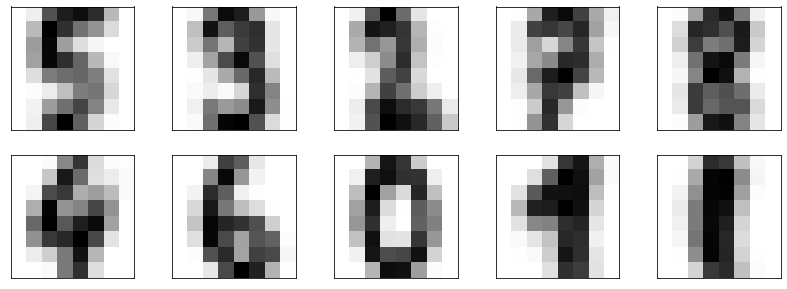

In [11]:
def draw_centers(predicted_labels):
    centers = []
    for num in np.unique(predicted_labels):
        centers.append(np.mean(X[predicted_labels == num], axis = 0))
    fig, axs = plt.subplots(2, 5, figsize=(14, 5))
    for n in range(10):
        axs[n // 5, n % 5].imshow(centers[n].reshape(8, 8), cmap=plt.cm.binary)
        axs[n // 5, n % 5].set_xticks([])
        axs[n // 5, n % 5].set_yticks([])

draw_centers(hierarchical_labels)

#### 𝐾-means clustering

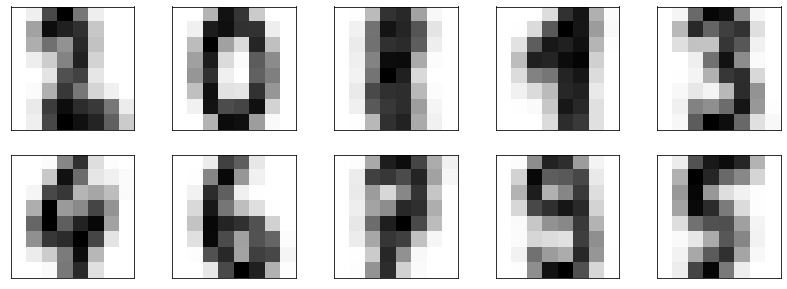

In [12]:
draw_centers(kmeans_labels)

In a situation where the true number of classes is unknown, we can select it by maximazing some metric.

When we can set some distance function between our observations, we can consider the `silhouette` distance as a function of measuring the quality of the clustering. Let's show how it is calculated:

Let $X$ – set of observations, $M \subset X$ – one of the clusters obtained as a result of clustering process, $\rho$ – some metric on $X$. Let's choose one observation $x \in M$. Denote $a(x)$ as the average distance from $x$ to  $x'$ points from the same cluster:
$$
a(x) = \frac{1}{|M| - 1} \sum_{x' \in M,\, x' \ne x} \rho(x,\, x')
$$

Denote $b(x)$ as minimun of average distances from $x$ to $x''$ from some other cluster $N$:
$$
b(x) = \min_{N \ne M} \frac{1}{|N|} \sum_{x'' \in N} \rho(x,\, x'')
$$

The silhouette is difference between a(x) and b(x), normalized to $[-1, \, 1]$ and averaged over all observations:
$$
\frac{1}{|X|} \sum_{x \in X} \frac{b(x) - a(x)}{\max(a(x),\, b(x))}
$$

The implementation of this metric in the `scikit-learn` is the `silhouette_score` function from the `metrics` submidule.

**(0.75 point)** For each $K$ between 2 and 20 inclusive, partition of the array $X$ into $K$ clusters using both methods. Calculate the silhouette score and visualize it for both methods on the same plot ($K$ on the $x$ axis and silhouette score on the $y$ axis). Sign the axes and make a legend.

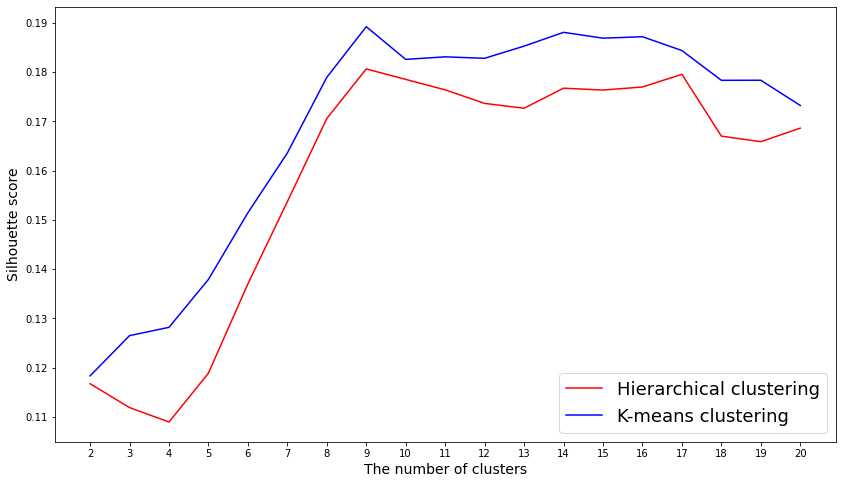

In [13]:
from sklearn.metrics import silhouette_score

plt.figure(figsize=(14, 8));
silhouette_hierarchy = []
silhouette_kmeans = []

for i in range(2, 21):
    hierarchy = AgglomerativeClustering(n_clusters=i)
    clusters_hierarchy = hierarchy.fit_predict(X)
    silhouette_hierarchy.append(silhouette_score(X, clusters_hierarchy))
    
    kmeans = KMeans(n_clusters=i, random_state=42, n_init=100)
    clusters_kmeans = kmeans.fit_predict(X)
    silhouette_kmeans.append(silhouette_score(X, clusters_kmeans))

plt.plot(range(2, 21), silhouette_hierarchy, color='red', label='Hierarchical clustering');
plt.plot(range(2, 21), silhouette_kmeans, color='blue', label='K-means clustering');
plt.xticks(range(2, 21));
plt.xlabel('The number of clusters', fontsize=14);
plt.ylabel('Silhouette score', fontsize=14);
plt.legend(fontsize=18);

When we know the true clustering labels, the clustering result can be compared to them using measures such as `homogeneity`, `completeness` and their harmonic mean - $V$-score. The definitions of these quantities are rather bulky and are based on the [entropy of the probability distribution](https://ru.wikipedia.org/wiki/Информационная_энтропия). Details are given in [this article](http://aclweb.org/anthology/D/D07/D07-1043.pdf). In practice, it's enough to know that `homogeneity`, `completeness` and $V$-score are in the range from 0 and 1, and the more, the better.

Since we know what digit each image is (`y` array), we can compare the clustering results to it using the measures listed above.

**(0.5 points)** Repeat the previous task using $V$-measure instead of silhouette.

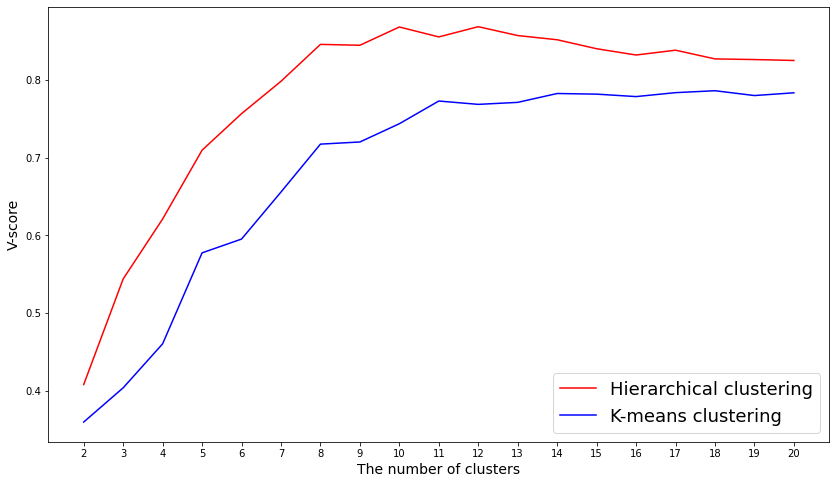

In [14]:
from sklearn.metrics import v_measure_score

plt.figure(figsize=(14, 8));
vscore_hierarchy = []
vscore_kmeans = []

for i in range(2, 21):
    hierarchy = AgglomerativeClustering(n_clusters=i)
    clusters_hierarchy = hierarchy.fit_predict(X)
    vscore_hierarchy.append(v_measure_score(y, clusters_hierarchy))
    
    kmeans = KMeans(n_clusters=i, random_state=42, n_init=100)
    clusters_kmeans = kmeans.fit_predict(X)
    vscore_kmeans.append(v_measure_score(y, clusters_kmeans))

plt.plot(range(2, 21), vscore_hierarchy, color='red', label='Hierarchical clustering');
plt.plot(range(2, 21), vscore_kmeans, color='blue', label='K-means clustering');
plt.xticks(range(2, 21));
plt.xlabel('The number of clusters', fontsize=14);
plt.ylabel('V-score', fontsize=14);
plt.legend(fontsize=18);

## 3. Feature space dimensionality reduction

In some cases, especially when there are a large number of features, when not all of them are informative, and some of them are correlated, it can be useful to reduce the dimension of the feature space. This mean that instead of $d$ original features, we will go to $d'\ll d$ new ones. And if earlier our data were presented in the form of an $n×d$ matrix, then it will presented as a $n×d'$.

There are two popular dimensionality reduction approaches:
- select new features from existing features;
- extract the new features by transforming old ones, for example, by making $d'$ different linear combinations of columns of an $n×d$ matrix.

One widely used dimensionality reduction technique is the Singular Value Decomposition (SVD). This method allows you to construct any number $d'\leq d$ of new features in such a way that they are the most informative (in some sense).

The `scikit-learn` module has several implementations of singular value decomposition. We will use the `TruncatedSVD` class from the `decomposition` submodule.

**Note:** The singular value decomposition of the matrix $M$ is usually written as $M=U \Sigma V^{*}$. `TruncatedSVD`, in turn, returns only the $d'$ first columns of the matrix $U$.

**(0.75 point)** Perform a singular value decomposition of the $X$ matrix, leaving 2, 5, 10, 20 features. In each case, perform hierarchical clustering and $K$-Means clustering (take the number of clusters equal to 10). Calculate the silhouette and $V$-score and compare them to corresponding values obtained from the original data.

**Note**: It is not valid to compare the silhouette calculated with different metrics. Even if we use the same metric function when calculating the distance between points in the data, after applying dimensionality reduction or other data transformations, we will (not always) get different silhouette scores. Therefore, after training the clustering algorithm, to compare the result of clustering, you need to calculate the silhouette on the original data.

In [15]:
df1 = pd.DataFrame(columns=["2", "5", "10", "20"])

from sklearn.decomposition import TruncatedSVD, PCA

for feat_left in [2, 5, 10, 20]:
    
    tr_SVD = TruncatedSVD(n_components=feat_left, random_state=42).fit_transform(X)
    
    hierarchy = AgglomerativeClustering(n_clusters=10)
    clusters_hierarchy = hierarchy.fit_predict(tr_SVD)
    
    kmeans = KMeans(n_clusters=10, random_state=42, n_init=100)
    clusters_kmeans = kmeans.fit_predict(tr_SVD)
    
    df1.loc["Silhouette: Hierarchical", str(feat_left)] = silhouette_score(X, clusters_hierarchy)
    df1.loc["Silhouette: K-means", str(feat_left)] = silhouette_score(X, clusters_kmeans)
    df1.loc["V-score: Hierarchical", str(feat_left)] = v_measure_score(y, clusters_hierarchy)
    df1.loc["V-score: K-means", str(feat_left)] = v_measure_score(y, clusters_kmeans)
    
df1

,2,5,10,20
Silhouette: Hierarchical,-0.007681,0.162011,0.176588,0.169133
Silhouette: K-means,0.006933,0.168533,0.180466,0.182246
V-score: Hierarchical,0.333719,0.675604,0.825975,0.814388
V-score: K-means,0.346396,0.635302,0.720355,0.742538


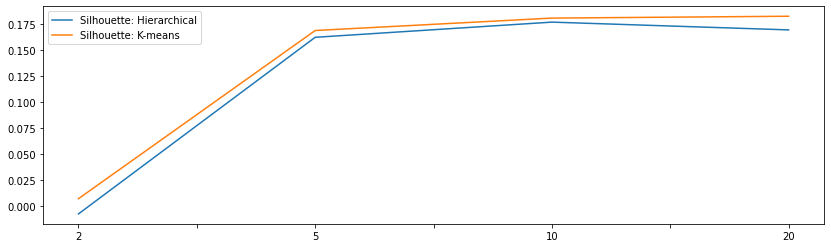

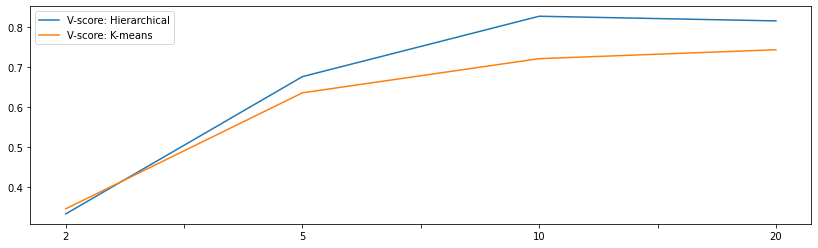

In [16]:
df1.iloc[:2, :].transpose().plot(figsize=(14, 4));
df1.iloc[2:, :].transpose().plot(figsize=(14, 4));

Another popular dimensionality reduction approach that is useful for working with images is t-distributed stochastic neighbor embeddings, abbreviated `tSNE`. Unlike singular value decomposition, this it is non-linear transformation. It's main idea is to map points from a space of dimension `d` to another space of dimension 2 or 3 in such a way that the distances between points are mostly preserved. Mathematical details can be found, for example, [here](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding).

The implementation of `tSNE` in the `scikit-learn` library is the `TSNE` class in the `manifold` submodule.

**Note:** In recent years [UMAP](https://github.com/lmcinnes/umap) is often used istead of `tSNE`. It is a faster algorithm with similar properties. We don't ask you to use `UMAP` because it requires you to install another dependency, the `umap-learn` library. Those who wish can perform the following task using `UMAP`.

**(0.5 points)** Perform a tSNE-transform of the `X` matrix, leaving 2 features. Visualize the obtained data in the form of a scatter plot form: the first feature on the horizontal axis, and the second one the vertical axis. Color the points according to the digits they belong to.

- The `c` parameter in the plt.scatter function is responsible for the color of the points. Pass the true labels to it.

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


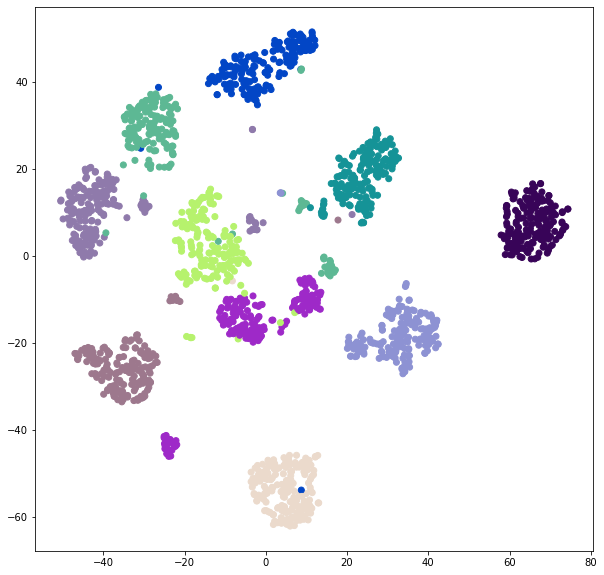

In [17]:
from sklearn.manifold import TSNE

X_TSNE = TSNE(n_components=2).fit_transform(X)
X_1 = [x[0] for x in X_TSNE]
X_2 = [x[1] for x in X_TSNE]

random_colors = np.random.rand(10, 3)
label_color = [random_colors[n] for n in y]

plt.figure(figsize=(10, 10));
plt.scatter(X_1, X_2, c=label_color);

**(0.5 points)** From the data transformed using the tSNE, perform hierarchical clustering and $K$-means clustering (take the number of clusters equal to 10). Calculate the silhouette and the $V$-score and compare them to corresponding values obtained from the original data.

In [18]:
df2 = pd.DataFrame()
df2.loc["Silhouette: Hierarchical", "Original data"] = silhouette_hierarchy[8]
df2.loc["Silhouette: K-means", "Original data"] = silhouette_kmeans[8]
df2.loc["V-score: Hierarchical", "Original data"] = vscore_hierarchy[8]
df2.loc["V-score: K-means", "Original data"] = vscore_kmeans[8]
    
hierarchy_TSNE = AgglomerativeClustering(n_clusters=10)
clusters_hierarchy_TSNE = hierarchy_TSNE.fit_predict(X_TSNE)
kmeans_TSNE = KMeans(n_clusters=10, random_state=42, n_init=100)
clusters_kmeans_TSNE = kmeans_TSNE.fit_predict(X_TSNE)
    
df2.loc["Silhouette: Hierarchical", "Transformed data"] = silhouette_score(X, clusters_hierarchy_TSNE)
df2.loc["Silhouette: K-means", "Transformed data"] = silhouette_score(X, clusters_kmeans_TSNE)
df2.loc["V-score: Hierarchical", "Transformed data"] = v_measure_score(y, clusters_hierarchy_TSNE)
df2.loc["V-score: K-means", "Transformed data"] = v_measure_score(y, clusters_kmeans_TSNE)

df2

,Original data,Transformed data
Silhouette: Hierarchical,0.178497,0.163835
Silhouette: K-means,0.182555,0.163731
V-score: Hierarchical,0.868170,0.907878
V-score: K-means,0.743719,0.903292


**(0.25 points)** Choose the best partition (in terms of silhouette or $V$-score) and visualize the centers of clusters with images. Did you managed to make each digit correspond to one center of the cluster?

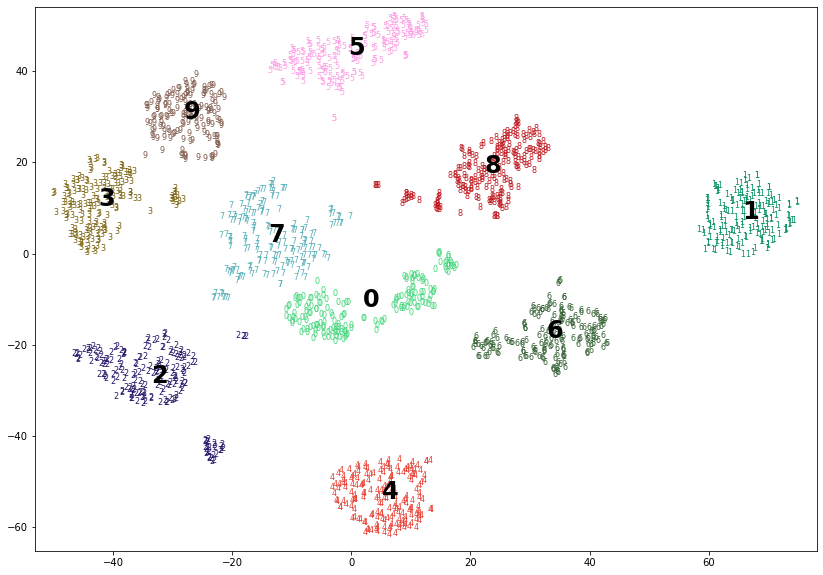

In [19]:
plt.figure(figsize=(14, 10));
random_colors = np.random.rand(10, 3);
true_label_names = {0: "0", 1: "8", 2: "1", 3: "9", 4: "4", 5: "6", 6: "2", 7: "5", 8: "3", 9: "7"}
label_color = [random_colors[n] for n in clusters_kmeans_TSNE]
for i in range(len(X)):
    plt.text(X_1[i], X_2[i], str(true_label_names[clusters_kmeans_TSNE[i]]), color=label_color[i], fontdict={'size': 8})
plt.xlim(min(X_1)*1.05, max(X_1)*1.05);
plt.ylim(min(X_2)*1.05, max(X_2)*1.05);
for n in range(10):
    plt.text(kmeans_TSNE.cluster_centers_[n][0], kmeans_TSNE.cluster_centers_[n][1], true_label_names[n], fontdict={'weight': 'bold', 'size': 24})

Image above illustrates that we managed to make each digit correspond to one center of the cluster.

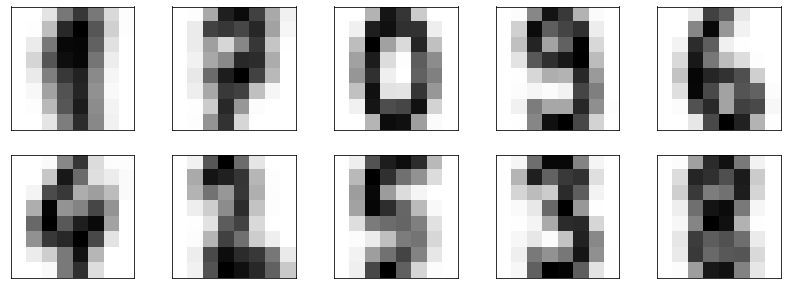

In [20]:
draw_centers(clusters_kmeans_TSNE)

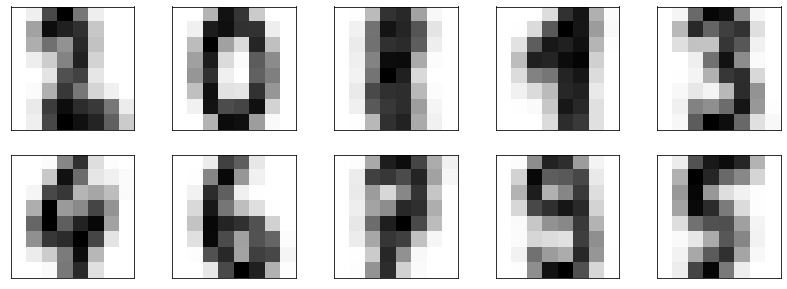

In [21]:
draw_centers(kmeans_labels)

Comparison (post t-SNE clustering is the former) shows that not only V-score increased, but some digits certainly recieved better representation: that is especially true for digit 8 and probably 1.

## 4. Results and bonus part

Write in free form what conclusions you made after completing this assignment. Answer the following questions:

**(0.5 points)** Which algorithm gives more meaningful results - hierarchical clustering or $K$- means clustering. Does it depend on the algorithm settings or on the quality evaluation method?

Personally I enjoyed hierarchical clustering a lot: not only it shows better results, these are also much easily interpreted (not that I'm saying K-means is not intuitive at all). Also, since from the start we knew we were working with digits, it was easier in terms of picking K-value. Unfortunately, hierarchical clustering's computational complexity doesn't allow us to use it on really big data (as I discovered further).  
While quality evaluation methods based on some gold standards are preferred, I doubt it's a common thing in real life. Nevetherless, when I compare metrics with cluster centers as digits, it feels like V-score is better as a predictor of "meaningful" outcome. Tuning algorithm settings is certainly a way to enhance model performance (as we show above).

**(0.5 points)** Imagine the situation where after hierarchical clustering, you need to cluster new data in the same way without retraining the model. Suggest a method how you will do it and how you will measure the quality of clustering of new data.

The easiest way to classify extra data is to make a function that takes centroids' "coordinates" and calculates pairwise distances between them and new observation. Label of the closest centroid would be the label for this observation. If we consider our basic clusterization to be "gold standard", we can use such quality metrics as Adjusted Rand index. Sillhouette score is readily available whether we have a reference or not.

**(0.5 points)** Does dimensionality reduction improve clustering results?

While this is not a primary target with dimensionality reduction, sometimes results do become better. Even though in most cases they become worse (probably due to some missing relationships in the "squished" data), in case of t-SNE we've got better classification. We know that the algorythm preserves spatial relationships between data points and that's why it doesnt make results worse like PCA does. Improvements that we see in case of t-SNE may be attributed to better "outliers" handling or finding non-linear dependencies (while PCA offers linear combinations only).

**(0.5 points)** How to evaluate the quality of dimensional reduction? Suggest at least 2 options.

The main purpose of applying dimensionality reduction on data is to capture the original data's distribution as much as possible even after the dimensionality reduction. Therefore, we want to make sure that we capture the variance of the data as much as we can. Exact methods depend on reduction method used. For instance, for PCA we can measure distance between original and "reconstructed" points.  
I also have a feeling that if dimensionality reduction is used exactly in order to achieve better model performance, well, the model performance after applying different reduction techniques (judged with relevant metrics) would indicate dimensionality reduction quality as well.

**(Bonus 2 points)** Load the [MNIST Handwritten Digits](http://yann.lecun.com/exdb/mnist) dataset. You can also do it with `scikit-learn` as explained [here](https://stackoverflow.com/a/60450028). Explore the data and try to cluster it using different approaches. Compare results of these approaches using the silhouette and the $V$-score.

In [22]:
from sklearn.datasets import fetch_openml
_X, _y = fetch_openml('mnist_784', version=1, return_X_y=True)

In [35]:
#X, X_test, y, y_test = train_test_split(_X, _y, test_size=0.0, random_state=42)
X, y = _X, _y

In [36]:
df3 = pd.DataFrame(columns=["Silhouette score", "V-score"])

#hierarchy_base = AgglomerativeClustering(n_clusters=10).fit_predict(X)
#df3.loc["Hierarchical (base)"] = [silhouette_score(X, hierarchy_base), v_measure_score(y, hierarchy_base)]
kmeans_base = KMeans(n_clusters=10, random_state=42, n_init=100).fit_predict(X)
df3.loc["K-means (base)"] = [silhouette_score(X, kmeans_base), v_measure_score(y, kmeans_base)]

X_SVD = TruncatedSVD(n_components=10, random_state=42).fit_transform(X)
#hierarchy_SVD = AgglomerativeClustering(n_clusters=10).fit_predict(X_SVD)
#df3.loc["Hierarchical (PCA dimension reduction)"] = [silhouette_score(X, hierarchy_SVD), v_measure_score(y, hierarchy_SVD)]
kmeans_SVD = KMeans(n_clusters=10, random_state=42, n_init=100).fit_predict(X_SVD)
df3.loc["K-means (PCA dimension reduction)"] = [silhouette_score(X_SVD, kmeans_SVD), v_measure_score(y, kmeans_SVD)]

X_TSNE = TSNE(n_components=2).fit_transform(X)
#hierarchy_TSNE = AgglomerativeClustering(n_clusters=10).fit_predict(X_TSNE)
#df3.loc["Hierarchical (TSNE dimension reduction)"] = [silhouette_score(X, hierarchy_TSNE), v_measure_score(y, hierarchy_TSNE)]
kmeans_TSNE = KMeans(n_clusters=10, random_state=42, n_init=100).fit_predict(X_TSNE)
df3.loc["K-means (TSNE dimension reduction)"] = [silhouette_score(X, kmeans_TSNE), v_measure_score(y, kmeans_TSNE)]

df3

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


,Silhouette score,V-score
K-means (base),0.058692,0.499744
K-means (PCA dimension reduction),0.169552,0.465823
K-means (TSNE dimension reduction),0.035591,0.768426


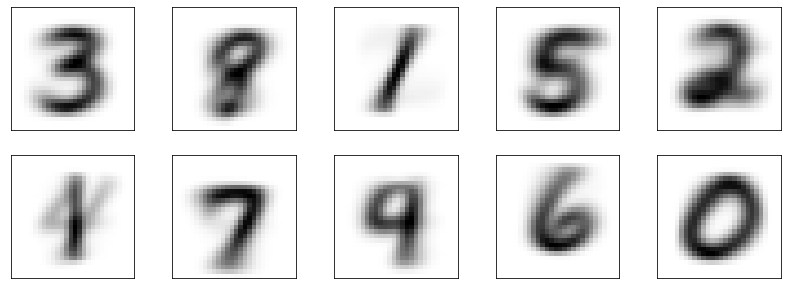

In [37]:
centers = []
for num in np.unique(kmeans_TSNE):
    centers.append(np.mean(X[kmeans_TSNE == num], axis = 0))
fig, axs = plt.subplots(2, 5, figsize=(14, 5))
for n in range(10):
    axs[n // 5, n % 5].imshow(centers[n].values.reshape(28, 28), cmap=plt.cm.binary)
    axs[n // 5, n % 5].set_xticks([])
    axs[n // 5, n % 5].set_yticks([])

I've got some pretty results for AgglomerativeClustering with t-SNE (on full data) but unfortunately can't show them since it's been running for two hours and I have no time to re-run it again :(
What we have here is K-means (bare, with PCA and t-SNE). Again, model with prior t-SNE performed much better, while PCA decreased the quality (measured with V-score). Digit 1 and 4 seem to be most troublesome in K-means models.